# Кластеризация K-средних
автор: [Владимир Сизов](mailto:vladimirsizov@yandex.ru)

Кластеризация K-средних распространённый алгоритм неконтролируемого машинного обучения.  
Определение кластеров осуществляется на схожести данных у экземпляров. 

Я изучил в теории принцип его работы, однако я хотел детально разобраться как эта магия работает. Для меня проще всего это сделать, если разобрать его на кусочки и смотреть как себя ведут данные в каждом блоке кода.

Ниже мы подробно рассмотрим метод подбора координат центройдов, разделения данных на кластеры, а также нарисуем результат на графике.

<hr>

Для работы этого алгоритма необходимо заранее определить количество кластеров.  

Импортируем необходимые библиотеки

In [63]:
import pandas as pd
import numpy as np
import statistics

import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (7, 7)})

При использовании этого алгоритма данные для кластеризации можно задавать в формате: \[x, y, z, ...\] 

В качестве примера мы сгенерируем двумерный массив \[x, y\]

In [64]:
np.random.seed(17)

x = [4, 6, 10, 13]
y = [3, 9, 14, 10]

cluster_x = []
cluster_y = []

for i in zip(x, y):
    cluster_x.append(np.random.normal(i[0], 1, 40))
    cluster_y.append(np.random.normal(i[1], 1.4, 40))

x = np.concatenate(cluster_x)
y = np.concatenate(cluster_y)

df = pd.DataFrame([i for i in zip(x, y)], columns=['x', 'y'])
df.head()

,x,y
0,4.276266,1.382421
1,2.145372,7.683220
2,4.623901,3.177418
3,5.145311,2.028150
4,5.037190,3.780744


Посмотрим как данные выглядят на графике:

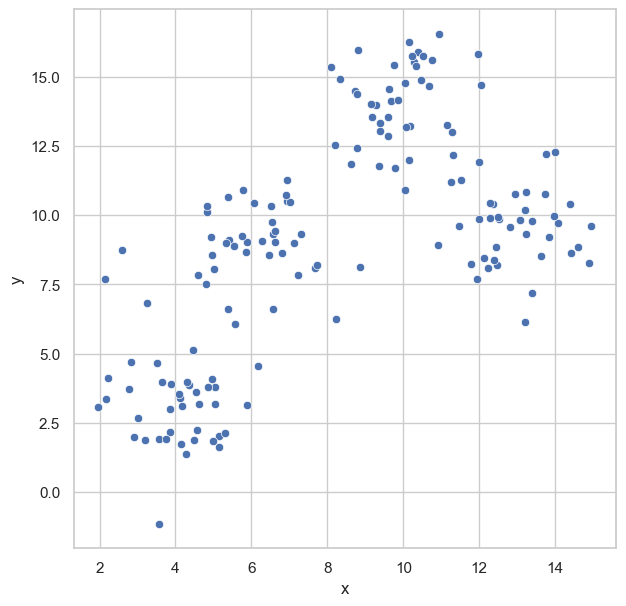

In [65]:
sns.scatterplot(data=df, x='x', y='y');

<hr>

Алгоритм кластеризации clusterization() выглядит следующим образом:  
Мы принимаем параметры df (с массивами значений x, y), а также clusters - число кластеров которые мы будем искать.  

Создаём список названия осей координат.  

Функция first_centroid() принимает данные координат и возвращает случайные первичные значения центройдов, а также список с их именами. 

Далее идет сам цикл подбора центройдов и определения кластера для каждой координаты while:  
Мы сохраняем последнее значение centroids в current_centroids, для последующего сравнения. 

С помощью функции cluster_update() мы получаем датафрейм, который включает:  
\- координаты  
\- Евклидово расстояние от координат до каждого центройда  
\- названием ближайшего кластера к которому определены координаты для каждой точки  

Собираем датафрейм с координатами центройдов

<hr>

Каждый кластер определяется центройдом и наиболее близко расположенным к нему облаку точек.  

По сути алгоритм заключается в том что центройды должны поделить все точки между собой таким образом, чтобы повторная итерация цикла while не давала изменения в переопределении значений координат центройдов - в этом случае это будет означать что кластеры определены и цикл должен прерваться.

Функция clusterization() возвращает датафрейм с координатами и названием кластера для каждой координаты, а также датафрейм с центройдами.

In [66]:
def clusterization(df, clusters): 
    axis = df.columns.to_list()
    # определяем первые значения центройдов
    centroids = first_centroid(df, clusters)[0]
    cnames = first_centroid(df, clusters)[1]
    while True:
        # считаем евклидово расстояние до центройдов
        current_centroids = centroids.copy()
        clustered = cluster_update(df, current_centroids, axis)
        # получаем средние значения кластеров
        centroids = means_clusters(clustered, cnames)
        if centroids == current_centroids:
            break
    # собираем центройды в датафрейм
    data = []
    for i in centroids:
        data.append(i[1])
    df_centroids = pd.DataFrame(data=data, columns=axis)
    df_centroids['centroids'] = cnames
    return {'data': clustered, 'centroids': df_centroids}

Ниже рассмотрим каждую функцию по отдельности.  
<hr>
Функция first_centroid() возврщает набор  координат для каждого центройда.  
Первичные координаты определяются равномерным распределением значений по каждой оси методом квантилей.
Например если распределение значений по оси х от 0 до 100 а кластеров должно быть 3, то значение для центройдов по оси x , будет 25, 50 и 75, аналогично и для других осей согласно их распределениям.
Это не пренципильно потому, что в процессе переопределения координат центройдов они в любом случае изменятся.  

В качестве примера мы судем строить три кластера, соответственно для начала попросим приготовить координаты трёх центройдов

In [67]:
def first_centroid(df, clusters):
    axis = df.columns.to_list()
    data = []
    for a in axis:
        data.append(statistics.quantiles(df[a], n=clusters+1))
    centroids = []
    cnames = []
    for a in range(clusters):
        cname = 'C' + str(a+1)
        coordinates = []
        for d in data:
            coordinates.append(d[a])
        centroids.append([cname, coordinates])
        cnames.append(cname)
    return [centroids, cnames]

centroids = first_centroid(df, 3)[0]
cnames = first_centroid(df, 3)[1]

centroids, cnames

([['C1', [4.988922093021953, 6.165445305223434]],
  ['C2', [8.276083348762793, 9.271751618612221]],
  ['C3', [11.419474874207697, 11.890005389244132]]],
 ['C1', 'C2', 'C3'])

В ответе под индексом \[0\] мы получаем координаты центройдов, под индексом \[1\] их имена. 

<hr>

Собственно функция для определения расстояния.  
Здесь мы построчно сравниваем значения колонок C1, C2 и C3, а в колонку cluster записываем название той колонки значение которой меньшее из всех кластеров, тем самым определяя к какому кластеру пренадлежат координаты каждой строки.

In [68]:
def get_cluster(clusters):
    i = 0
    cluster_name = ''
    cluster_value = 0
    for name, value in clusters.items():
        if i == 0:
            cluster_name = name
            cluster_value = value
            i += 1
        else:
            if value < cluster_value:
                cluster_name = name
                cluster_value = value
    return cluster_name

 <hr>

Функция cluster_update() перебирает датафрейм по строкам. 

В процессе обработки новые данные для каждой строки постепенно добавляются в словарь new_row, а в конце перебора дополненый датафрейм построчно собирается заново.  
\- переменная row хранит координаты, их мы добавляем в первую очередь  
\- затем мы определяем Евклидово расстояние от координаты до центройда, мы это делаем для каждого центройда по очереди, по формуле:  

<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSv1ymHbY7ecuBOJMQzckZIkfKfOLgTvt3IJg&usqp=CAU' width=320, heigth=240>

попутно каждое Евклидово расстояние мы аккуратно складываем в словарь clusters, для того чтобы когда мы соберём все расстояния до кластеров для каждой координаты - мы сравним их и через функцию get_cluster() определим самое меньшее тем самым указав в столбце clusters имя кластера к которому она пренадлежит.

In [69]:
def cluster_update(df, centroids, axis):
    # добавляем евклидово расстояние до центройдов
    data = []
    for r in range(len(df)):
        row = df.loc[r]
        new_row = {}
        # добавляем оси
        for a in range(len(row)):
            new_row[row.index[a]] = row[a]
        data.append(new_row)
        # добавляем евклидово расстояние до каждого кластера
        clusters = {}
        for c in range(len(centroids)):
            name_centroid = centroids[c][0]
            result = []
            for a in range(len(row)):
                diff = row[a] - centroids[c][1][a]
                result.append(diff)
            euclid = sum(np.array(result)**2)**0.5
            # добавляем центройды
            new_row[name_centroid] = euclid
            clusters[name_centroid] = euclid
        # подбираем текущий кластер
        new_row['cluster'] = get_cluster(clusters)
    return pd.DataFrame(data)


axis = df.columns.to_list()

print('\nтаблица выгладит так:')
df = cluster_update(df, centroids, axis)
df.head()


таблица выгладит так:


,x,y,C1,C2,C3,cluster
0,4.276266,1.382421,4.835824,8.845342,12.705698,C1
1,2.145372,7.683220,3.223262,6.333171,10.183616,C1
2,4.623901,3.177418,3.010240,7.104881,11.049389,C1
3,5.145311,2.028150,4.140250,7.891230,11.688513,C1
4,5.037190,3.780744,2.385190,6.375076,10.319577,C1


<hr>
Функция means_clusters() выполняет обработку датафрейма полученного функцией cluster_update.
Суть переопределения новых координат для центройдов достаточно проста:  
Мы группируем данные по колонке cluster, при этом в сагригированных данных для каждого кластера в итоге мы получаем среднее значение каждой координатной оси - это и есть наши новые координаты.

Точка центройда какбы переползает по координатной плоскости ориентируясь на максимальный захват соседних точек, но так как центройдов несколько и у части окружающих точек Евклидово расстояние ближе до какого-то определённого центройда кластеры распределяют точки равномерно.

In [70]:
def means_clusters(df, cnames):
    df.drop(cnames, axis=1, inplace=True)
    axis = df.columns.to_list()
    axis.remove('cluster')
    df = df.groupby('cluster')[axis].agg('mean')
    means = []
    for c in cnames:
        axis_values = []
        for a in axis:
            axis_values.append(df.loc[c][a])
        means.append([c, axis_values])
    return means

means_clusters(df, cnames)

[['C1', [4.212410276999089, 4.115998093756059]],
 ['C2', [7.265286445034083, 9.330839544388464]],
 ['C3', [11.446105070397715, 12.063727045143201]]]

Всё вместе это выглядит так:

In [71]:
def first_centroid(df, clusters):
    axis = df.columns.to_list()
    data = []
    for a in axis:
        data.append(statistics.quantiles(df[a], n=clusters+1))
    centroids = []
    cnames = []
    for a in range(clusters):
        cname = 'C' + str(a+1)
        coordinates = []
        for d in data:
            coordinates.append(d[a])
        centroids.append([cname, coordinates])
        cnames.append(cname)
    return [centroids, cnames]


def get_cluster(clusters):
    i = 0
    cluster_name = ''
    cluster_value = 0
    for name, value in clusters.items():
        if i == 0:
            cluster_name = name
            cluster_value = value
            i += 1
        else:
            if value < cluster_value:
                cluster_name = name
                cluster_value = value
    return cluster_name


def cluster_update(df, centroids, axis):
    # добавляем евклидово расстояние до центройдов
    data = []
    for r in range(len(df)):
        row = df.loc[r]
        new_row = {}
        # добавляем оси
        for a in range(len(row)):
            new_row[row.index[a]] = row[a]
        data.append(new_row)
        # добавляем евклидово расстояние до каждого кластера
        clusters = {}
        for c in range(len(centroids)):
            name_centroid = centroids[c][0]
            result = []
            for a in range(len(row)):
                diff = row[a] - centroids[c][1][a]
                result.append(diff)
            euclid = sum(np.array(result)**2)**0.5
            # добавляем центройды
            new_row[name_centroid] = euclid
            clusters[name_centroid] = euclid
        # подбираем текущий кластер
        new_row['cluster'] = get_cluster(clusters)
    return pd.DataFrame(data)


def means_clusters(df, cnames):
    df.drop(cnames, axis=1, inplace=True)
    axis = df.columns.to_list()
    axis.remove('cluster')
    df = df.groupby('cluster')[axis].agg('mean')
    means = []
    for c in cnames:
        axis_values = []
        for a in axis:
            axis_values.append(df.loc[c][a])
        means.append([c, axis_values])
    return means
    
def clusterization(df, clusters): 
    axis = df.columns.to_list()
    # определяем первые значения центройдов
    centroids = first_centroid(df, clusters)[0]
    cnames = first_centroid(df, clusters)[1]
    while True:
        # считаем евклидово расстояние до центройдов
        current_centroids = centroids.copy()
        clustered = cluster_update(df, current_centroids, axis)
        # получаем средние значения кластеров
        centroids = means_clusters(clustered, cnames)
        if centroids == current_centroids:
            break
    # собираем центройды в датафрейм
    data = []
    for i in centroids:
        data.append(i[1])
    df_centroids = pd.DataFrame(data=data, columns=axis)
    df_centroids['centroids'] = cnames
    return {'data': clustered, 'centroids': df_centroids}

Мы вызовем функцию clusterization() и попросим разделить координаты на 3 кластера

In [74]:
# создадим данные
df = pd.DataFrame([i for i in zip(x, y)], columns=['x', 'y'])

# кластеризуем
result = clusterization(df, 3)

# посмотрим на результат
data = result['data']
centroids = result['centroids']
display(df.head())
display(data.head())
display(centroids)

,x,y
0,4.276266,1.382421
1,2.145372,7.683220
2,4.623901,3.177418
3,5.145311,2.028150
4,5.037190,3.780744


,x,y,cluster
0,4.276266,1.382421,C1
1,2.145372,7.683220,C2
2,4.623901,3.177418,C1
3,5.145311,2.028150,C1
4,5.037190,3.780744,C1


,x,y,centroids
0,4.091202,2.975784,C1
1,5.970509,8.876121,C2
2,11.396381,11.853803,C3


Нарисуем

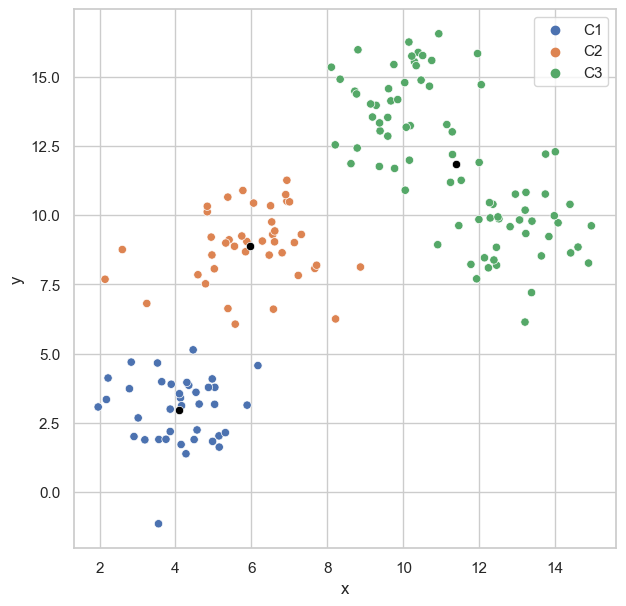

In [75]:
sns.scatterplot(data=data, x='x', y='y', hue='cluster');
sns.scatterplot(data=centroids, x='x', y='y', color='black');